# **Visualization and Table**
This Jupyter Notebook contains the loading, processing, evaluation, and visualization of the case study results from DSEN and baselines. 

**Contents:**
- Import and processing of case study results
- Evaluation of results based on metrics
- Clustering analysis of evolutionary feature

In [82]:
import numpy as np
import geopandas as gpd
import pandas as pd
import pickle
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from shapely.geometry import LineString, Point
import contextily as ctx
from scipy.stats import pearsonr, entropy, spearmanr
from matplotlib.colors import to_rgb, to_hex

from sklearn.cluster import SpectralClustering
from geopy.distance import geodesic

from tqdm import tqdm
import os

In [80]:
def common_part_of_commuters(generated_flow_flat, real_flow_flat, numerator_only=False):
    """
    The implementation of common_part_of_commuters
    :param generated_flow:
    :param real_flow:
    :param numerator_only:
    :return: The value of CPC
    """

    filtered_real_flow = real_flow_flat#[nonzero_indices]
    filtered_generated_flow = generated_flow_flat#[nonzero_indices]

    # Ensure non-negative values for real flow (though in this case it already is)
    filtered_real_flow = np.maximum(filtered_real_flow, 0)

    # Calculate CPC (Common Part of Commuters)
    numerator = 2 * np.sum(np.minimum(filtered_real_flow, filtered_generated_flow))
    denominator = np.sum(filtered_real_flow + filtered_generated_flow)
    cpc = numerator / denominator if denominator != 0 else 0.0

    return cpc

def interval_eva(df, bin_edges, infer_flow_name, real_flow_name = 'flow_w'):
    cpc_ls = []
    corr_ls = []
    nrmse_ls = []
    mape_ls = []
    for i in range(len(bin_edges)):
        if i==len(bin_edges)-1:
            break
        quantile = df[(df[real_flow_name]<bin_edges[i+1]) & (df[real_flow_name]>=bin_edges[i])]
        real_flow = quantile[real_flow_name].values
        inferred_flow = quantile[infer_flow_name].values

        cpc = common_part_of_commuters(real_flow,inferred_flow)
        corr,_ = pearsonr(inferred_flow, real_flow)
        nrmse = np.sqrt(np.mean((inferred_flow - real_flow) ** 2))
        mape = np.mean(np.abs((real_flow - inferred_flow) / real_flow)) * 100

        cpc_ls.append(cpc)
        corr_ls.append(corr)
        nrmse_ls.append(nrmse)
        mape_ls.append(mape)
        
    return {'cpc':cpc_ls, 'corr':corr_ls, 'nrmse': nrmse_ls, 'mape':mape_ls}

def find_xy_att_w(flow_df,TCMA_cbg):

    cbg_TCMA_center = TCMA_cbg.copy()
    cbg_TCMA_center = cbg_TCMA_center[['CensusBlockGroup', 'geometry']]
    cbg_TCMA_center['center'] = cbg_TCMA_center.centroid
    
    flow_df['start_lat']=None
    flow_df['start_lon']=None
    flow_df['end_lat']=None
    flow_df['end_lon']=None

    for index, row in tqdm(cbg_TCMA_center.iterrows()):
        start_lat = row['center'].y
        start_lon = row['center'].x
        end_lat = row['center'].y
        end_lon = row['center'].x
        # print(type(row['CensusBlockGroup']))
        flow_df.loc[flow_df.o_cbg==int(row['CensusBlockGroup']), 'start_lat']=start_lat
        flow_df.loc[flow_df.o_cbg==int(row['CensusBlockGroup']), 'start_lon']=start_lon
        flow_df.loc[flow_df.d_cbg==int(row['CensusBlockGroup']), 'end_lat']=end_lat
        flow_df.loc[flow_df.d_cbg==int(row['CensusBlockGroup']), 'end_lon']=end_lon

    return flow_df

def flow_npy2df(edge_index, flow_weight, cbg_list):
    
    '''
    edge_index: np array (2, x), O index: edge_index[0], D index: edge_index[1]
    flow_weight: np array
    '''
    
    edge_index_cp = edge_index.copy()
    for index,cbg in tqdm(enumerate(cbg_list)):
        edge_index_cp[edge_index_cp == index] = cbg
        
#     print(flow_weight)

    flow_df = pd.DataFrame({'o_cbg':edge_index_cp[0],'d_cbg':edge_index_cp[1], 'flow_w':flow_weight})
    
    return flow_df

def truncate4(x):
    """
    Truncate a number x to 4 decimal places without rounding.
    For positive numbers, it uses math.floor; for negatives, math.ceil.
    """
    factor = 10 ** 4
    if x >= 0:
        return math.floor(x * factor) / factor
    else:
        return math.ceil(x * factor) / factor

# 1. Baseline comparison (Table 1)

In [5]:
root_path = 'data/'
TCMA_cbg=gpd.read_file(root_path+'cbg_TCMA.geojson')
cbg_list = TCMA_cbg.CensusBlockGroup.to_list()

In [50]:
ground_truth_path = 'data/'

train_nonzero_flow = np.load(ground_truth_path+'Random_622/42/train_nonzero_flow.npy')
val_nonzero_flow = np.load(ground_truth_path+'Random_622/42/val_nonzero_flow.npy')  
test_nonzero_flow = np.load(ground_truth_path+'Random_622/42/test_nonzero_flow.npy')

In [12]:
sorted_values = np.sort(test_nonzero_flow[:,-1])
log_values = np.log(sorted_values)
log_bins = np.linspace(log_values.min(), log_values.max(), 5)
bin_edges = [int(i) for i in np.exp(log_bins)]
bin_edges[-1] = int(sorted_values.max())

In [87]:
y_pred_before = np.load('baselines/GM_before.npy') 
y_pred_during_xmas = np.load('baselines/GM_during_xmas.npy')
y_pred_change_rate = np.load('baselines/PGM_OLS.npy')
test_nonzero_flow_df = flow_npy2df(test_nonzero_flow[:,:2].T, test_nonzero_flow[:,2], cbg_list)
test_nonzero_flow_df_xy = find_xy_att_w(test_nonzero_flow_df, TCMA_cbg)
reg_results_testset = test_nonzero_flow_df.iloc[:,:].copy()
reg_results_testset['y_pred_before'] = y_pred_before
reg_results_testset['y_pred_change_rate'] = y_pred_change_rate
reg_results_testset['y_pred_during_xmas'] = y_pred_during_xmas

DPG_test = pd.read_csv('baselines/PGM_MLP_flow_test_set.csv')
for index, cbg in tqdm(enumerate(cbg_list)):
    DPG_test.loc[DPG_test.o==index, 'o']=int(cbg)
    DPG_test.loc[DPG_test.d==index, 'd']=int(cbg)
DPG_test.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w']
DPG_test_results = find_xy_att_w(DPG_test.copy(), TCMA_cbg)

DG_test = pd.read_csv('baselines/Deepgravity_flow_test_set.csv')
for index, cbg in tqdm(enumerate(cbg_list)):
    DG_test.loc[DG_test.o==index, 'o']=int(cbg)
    DG_test.loc[DG_test.d==index, 'd']=int(cbg)
DG_test.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w']
DG_test_results = find_xy_att_w(DG_test.copy(), TCMA_cbg)

SIGCN_df = pd.read_csv('baselines/SIGCN_flow_test_set.csv')
for index, cbg in tqdm(enumerate(cbg_list)):
    SIGCN_df.loc[SIGCN_df.o==index, 'o']=int(cbg)
    SIGCN_df.loc[SIGCN_df.d==index, 'd']=int(cbg)
SIGCN_df.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w']

IIDS = pd.read_csv('baselines/IIDS_results.csv')
IIDS_selected = IIDS[IIDS.flow_w!=0]

2085it [00:00, 192840.50it/s]
/tmp/ipykernel_1017752/125161231.py:63: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbg_TCMA_center['center'] = cbg_TCMA_center.centroid
2085it [00:02, 833.86it/s]
2085it [00:00, 3342.65it/s]
/tmp/ipykernel_1017752/125161231.py:63: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbg_TCMA_center['center'] = cbg_TCMA_center.centroid
2085it [00:01, 1100.46it/s]
2085it [00:00, 3357.45it/s]
/tmp/ipykernel_1017752/125161231.py:63: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbg_TCMA_center['center'] = cbg_TCMA_center.centroid
2085it [00:01, 1098

In [67]:
DSEN_evo = pd.read_csv('DSEN_results/results_full_DSEN.csv')
for index, cbg in tqdm(enumerate(cbg_list)):
    DSEN_evo.loc[DSEN_evo.o==index, 'o']=int(cbg)
    DSEN_evo.loc[DSEN_evo.d==index, 'd']=int(cbg)
    
DSEN_evo.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w']
DSEN_evo_results = find_xy_att_w(DSEN_evo.copy(), TCMA_cbg)

2085it [00:00, 2495.02it/s]


In [88]:
def eva_matrix(df, infer_flow_name, real_flow_name='flow_w'):
    real_flow = df[real_flow_name].values
    inferred_flow = df[infer_flow_name].values

    cpc = common_part_of_commuters(real_flow, inferred_flow)
    corr, _ = pearsonr(inferred_flow, real_flow)
    rmse = np.sqrt(np.mean((inferred_flow - real_flow) ** 2))
    mape = np.mean(np.abs((real_flow - inferred_flow) / real_flow)) * 100

    # Return metrics instead of printing
    return cpc, rmse, corr, mape

model_list = [
    ("GM $P_{t_1}$",       reg_results_testset, "y_pred_before"),
    ("GM $P_{t_2}$",  reg_results_testset, "y_pred_during_xmas"),
    ("DGM",               DG_test,     "Predict_flow"),
    ("IIDS",               IIDS_selected,     "Predict_flow"),
    ("PGM-OLS",  reg_results_testset, "y_pred_change_rate"),
    ("PGM-MLP",              DPG_test,    "Predict_flow"),
    ("SI-GCN",            SIGCN_df,       "Predict_flow"),
    ("DSEN",             DSEN_evo,    "Predict_flow")
]

results = []
for model_name, df_data, pred_col in model_list:
    cpc, rmse, corr, mape = eva_matrix(df_data, pred_col)
    results.append([model_name, cpc, rmse, corr, mape])

# Create a DataFrame with the desired columns
results_df = pd.DataFrame(results, columns=["Model", "CPC", "RMSE", "Corr", "MAPE"])

# Print or display the DataFrame
for col in ["CPC", "RMSE", "Corr", "MAPE"]:
    results_df[col] = results_df[col].apply(truncate4)
results_df

,Model,CPC,RMSE,Corr,MAPE
0,GM $P_{t_1}$,0.8054,2.6392,0.4503,30.6414
1,GM $P_{t_2}$,0.8070,2.6276,0.4665,30.5452
2,DGM,0.3155,16.7212,0.5276,517.4548
3,IIDS,0.0681,4.5933,0.1028,104.3046
4,PGM-OLS,0.8077,2.6190,0.4687,30.3792
5,PGM-MLP,0.8374,2.1018,0.6917,26.7187
6,SI-GCN,0.8138,2.3464,0.5747,31.9141
7,DSEN,0.8525,1.7502,0.8032,25.8655


# 2. Small v.s. large flow (Figure 4)

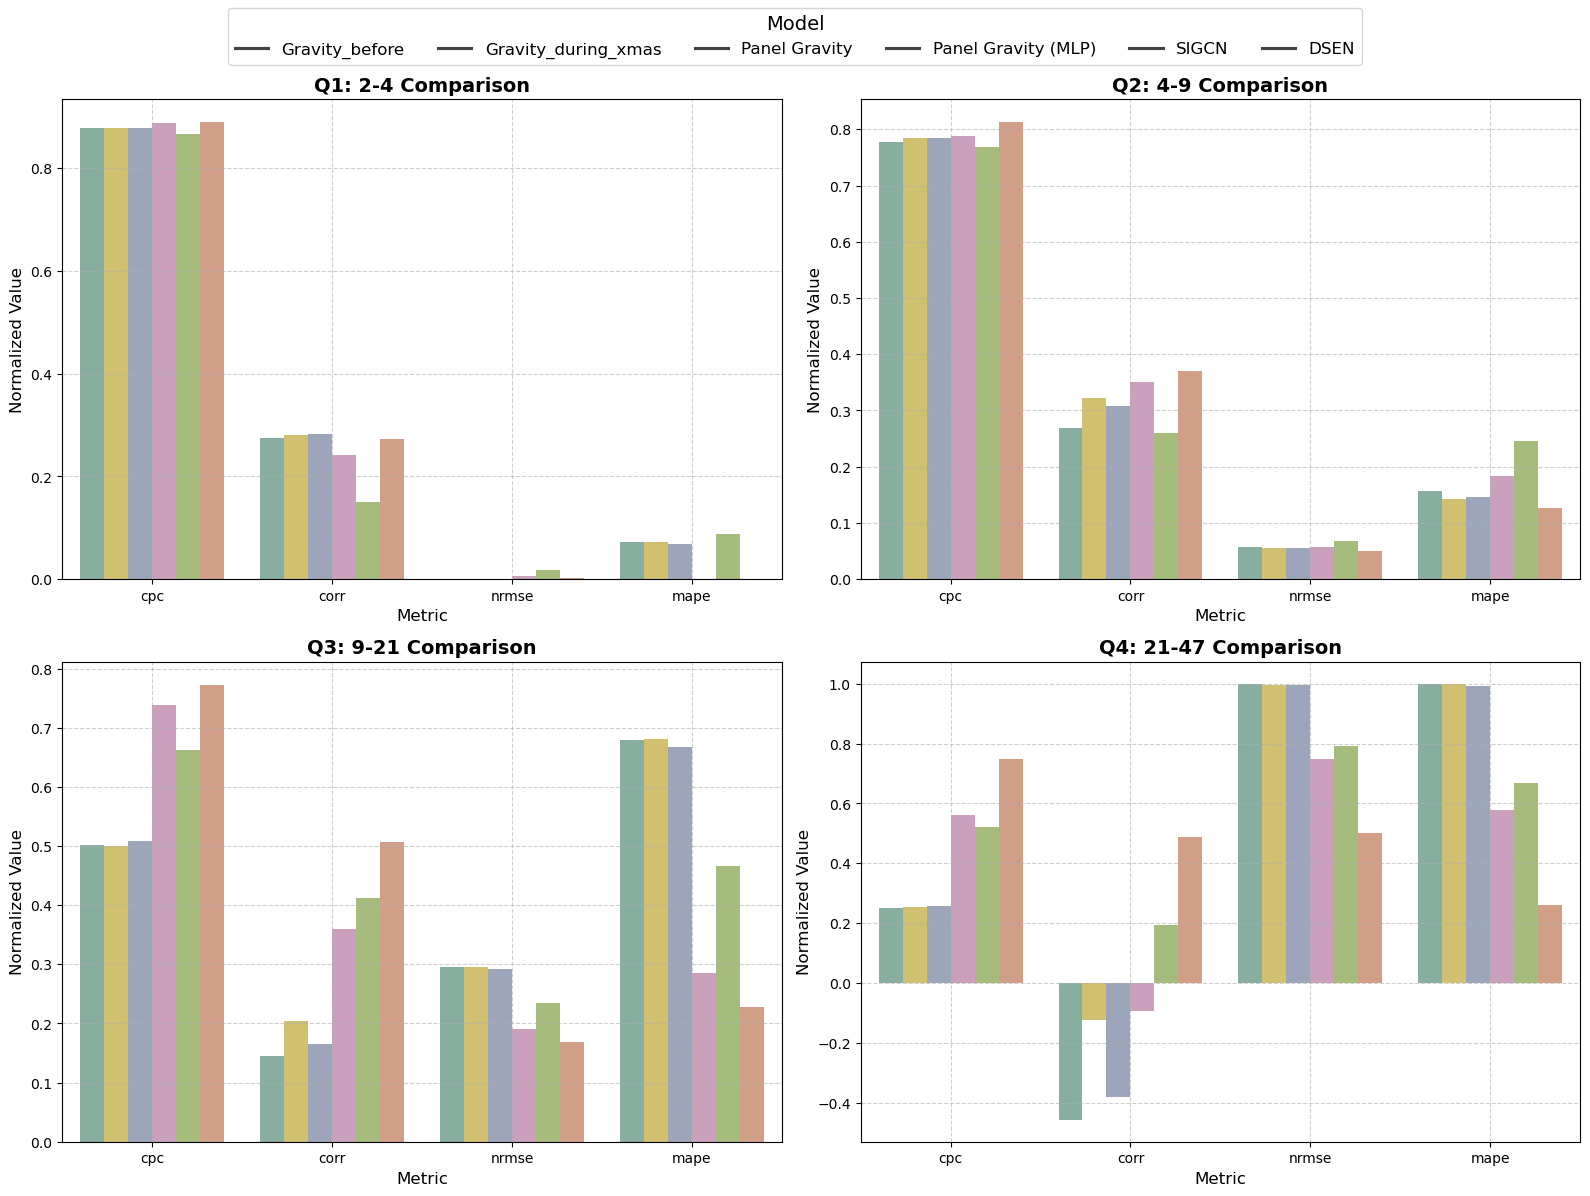

In [72]:
g_eva_before = interval_eva(reg_results_testset, bin_edges, 'y_pred_before', 'flow_w')
g_eva_during_xmas = interval_eva(reg_results_testset, bin_edges, 'y_pred_during_xmas', 'flow_w')
pg_eva = interval_eva(reg_results_testset, bin_edges, 'y_pred_change_rate', 'flow_w')
dpg_eva = interval_eva(DPG_test, bin_edges, 'Predict_flow', 'flow_w')
dg_eva = interval_eva(DG_test, bin_edges, 'Predict_flow', 'flow_w')
DSEN_eva = interval_eva(DSEN_evo, bin_edges, 'Predict_flow', 'flow_w')
SIGCN = interval_eva(SIGCN_df, bin_edges, 'Predict_flow', 'flow_w')

# Define the manual color mapping based on extracted colors
color_palette = {
    'Gravity_before': '#82B4A2',
    'Gravity_during_xmas': '#E0CA60',
    'Panel Gravity': '#98A3C0',
    'Panel Gravity (MLP)': '#D199BE',
    'SIGCN': '#AAC771',
    'DSEN': '#DD9A7B'
}

adjusted_colors = {k: to_hex(to_rgb(v)) for k, v in color_palette.items()}

# Combine dictionaries into a list
dicts = [g_eva_before, g_eva_during_xmas, pg_eva, dpg_eva, SIGCN, DSEN_eva]
dict_names = list(color_palette.keys())
metrics = list(g_eva_before.keys())

# Find the minimum length of available data to avoid indexing issues
min_length = min(len(d['nrmse']) for d in dicts)

# Step 1: Collect all values across all methods and bins for NRMSE and MAPE
all_nrmse_values = [d['nrmse'][i] for d in dicts for i in range(min_length)]
all_mape_values = [d['mape'][i] for d in dicts for i in range(min_length)]

# Step 2: Calculate the global min and max for normalization
nrmse_min, nrmse_max = np.min(all_nrmse_values), np.max(all_nrmse_values)
mape_min, mape_max = np.min(all_mape_values), np.max(all_mape_values)

# Step 3: Normalize the values across all methods using the global min and max
def normalize_global(metric_name, metric_values):
    if metric_name == 'nrmse':
        return (np.array(metric_values) - nrmse_min) / (nrmse_max - nrmse_min)
    elif metric_name == 'mape':
        return (np.array(metric_values) - mape_min) / (mape_max - mape_min)
    else:
        return np.array(metric_values)  # No normalization for CPC and CORR

# Step 4: Normalize all metrics in each dictionary
normalized_dicts = [
    {metric: normalize_global(metric, d[metric][:min_length]) for metric in metrics}
    for d in dicts
]

# Step 5: Prepare the figure with subplots (one for each bin)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, bin_label in enumerate([f'Q{i+1}: {bin_edges[i]}-{bin_edges[i+1]}' for i in range(min_length)]):
    bin_values = {metric: [d[metric][i] for d in normalized_dicts] for metric in metrics}
    bin_df = pd.DataFrame(bin_values, index=dict_names).reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
    bin_df.rename(columns={'index': 'Model'}, inplace=True)

    # Plot the data with manually defined color palette
    sns.barplot(data=bin_df, x='Metric', y='Value', hue='Model', ax=axes[i], palette=adjusted_colors)
    axes[i].set_title(f'{bin_label} Comparison', fontsize=14, weight='bold')
    axes[i].set_xlabel('Metric', fontsize=12)
    axes[i].set_ylabel('Normalized Value', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Remove individual legends if they exist
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Create a single legend outside the subplots
fig.legend(dict_names, title="Model", loc="upper center", ncol=len(dict_names), fontsize=12, title_fontsize=14, frameon=True)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 3. Model variants comparison (Table 2)

In [89]:
DSEN_no_evo_feature = pd.read_csv('ablation_study/DSEN_without_evo_feature.csv')
for index, cbg in tqdm(enumerate(cbg_list)):
    DSEN_no_evo_feature.loc[DSEN_no_evo_feature.o==index, 'o']=int(cbg)
    DSEN_no_evo_feature.loc[DSEN_no_evo_feature.d==index, 'd']=int(cbg)  
DSEN_no_evo_feature.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w']

DSEN_single_GAT = pd.read_csv('ablation_study/DSEN_without_cross_event.csv')
for index, cbg in tqdm(enumerate(cbg_list)):
    DSEN_single_GAT.loc[DSEN_single_GAT.o==index, 'o']=int(cbg)
    DSEN_single_GAT.loc[DSEN_single_GAT.d==index, 'd']=int(cbg)
DSEN_single_GAT.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w']

DSEN_two_MLP = pd.read_csv('ablation_study/DSEN_without_geo_context.csv')
for index, cbg in tqdm(enumerate(cbg_list)):
    DSEN_two_MLP.loc[DSEN_two_MLP.o==index, 'o']=int(cbg)
    DSEN_two_MLP.loc[DSEN_two_MLP.d==index, 'd']=int(cbg)
DSEN_two_MLP.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w']

model_variants_list = [
    ("DSEN without evolutionary feature",       DSEN_no_evo_feature, "Predict_flow"),
    ("DSEN without cross-event context",  DSEN_single_GAT, "Predict_flow"),
    ("DSEN without geographic context",  DSEN_two_MLP, "Predict_flow"),
    ("DSEN",  DSEN_evo_results,    "Predict_flow")
]

results = []
for model_name, df_data, pred_col in model_variants_list:
    cpc, rmse, corr, mape = eva_matrix(df_data, pred_col)
    results.append([model_name, cpc, rmse, corr, mape])

# Create a DataFrame with the desired columns
results_df = pd.DataFrame(results, columns=["Model", "CPC", "RMSE", "Corr", "MAPE"])

# Print or display the DataFrame
for col in ["CPC", "RMSE", "Corr", "MAPE"]:
    results_df[col] = results_df[col].apply(truncate4)
results_df

2085it [00:00, 2459.58it/s]
2085it [00:00, 2476.64it/s]
2085it [00:00, 2742.62it/s]


,Model,CPC,RMSE,Corr,MAPE
0,DSEN without evolutionary feature,0.8485,1.8842,0.7731,25.6052
1,DSEN without cross-event context,0.8512,1.8170,0.7769,25.1140
2,DSEN without geographic context,0.8465,1.9320,0.7534,26.0954
3,DSEN,0.8525,1.7502,0.8032,25.8655


# 4. Exploration of evolutionary feature and bidirectional flow (Figure 5)

In [57]:
evo_feature = np.load('DSEN_results/all_flow_evo_feature.npy')
all_flow_cat = np.load('data/Random_622/42/all_flow.npy')

selected_class_num = 4
spectral_model = SpectralClustering(
    n_clusters=selected_class_num,           
    affinity='nearest_neighbors',  
    n_neighbors=15,          
    random_state=42
)

# Fit the model and get cluster labels
cluster_labels = spectral_model.fit_predict(evo_feature)

2085it [00:00, 2143.18it/s]
/tmp/ipykernel_1017752/3381956745.py:63: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbg_TCMA_center['center'] = cbg_TCMA_center.centroid
2085it [00:02, 1038.64it/s]
100%|██████████| 13422/13422 [00:01<00:00, 7308.51it/s]


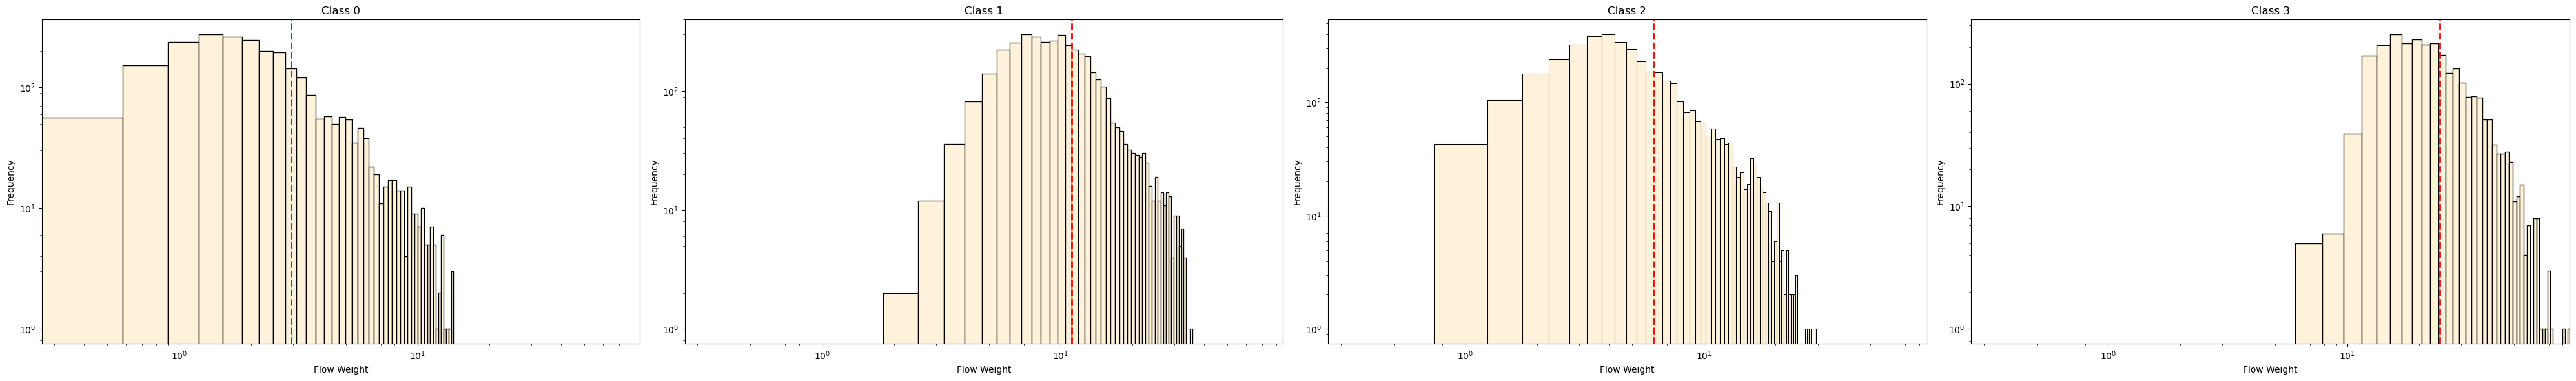

In [58]:
evo_class_edge = pd.DataFrame({'o_cbg':all_flow_cat[:,0], 
                               'd_cbg':all_flow_cat[:,1],
                               'flow_w':all_flow_cat[:,2],
                               'class':cluster_labels})

for index, cbg in tqdm(enumerate(cbg_list)):
    evo_class_edge.loc[evo_class_edge.o_cbg==index, 'o_cbg']=int(cbg)
    evo_class_edge.loc[evo_class_edge.d_cbg==index, 'd_cbg']=int(cbg)
    
evo_class_edge_xy = find_xy_att_w(evo_class_edge.copy(), TCMA_cbg)

def get_distance(df):
    distances = []

    # Iterate over each row in the DataFrame and calculate the geodesic distance
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        start_coords = (row['start_lat'], row['start_lon'])
        end_coords = (row['end_lat'], row['end_lon'])

        # Calculate geodesic distance
        distance = geodesic(start_coords, end_coords).km
        distances.append(distance)

    # Add the calculated distances as a new column in the DataFrame
    df_cp = df.copy()
    df_cp['dist_km'] = distances
    
    return df_cp

def flow_dis_diff_class(data, class_tot_num, att, save_path, log_axes=False):
    """
    Visualize flow distributions for different classes using Seaborn.

    Args:
        data: DataFrame containing the flow data.
        class_tot_num: Total number of classes.
        att: Attribute to visualize (e.g., 'flow_w').
        save_path: Path to save the visualization.
    """
    # Calculate the global x-axis limits across all claselected_class_num
    global_min = data[att].min()
    global_max = data[att].max()

    # Calculate subplot grid size
    cols = 4  # Number of columns in the grid
    if class_tot_num < cols:
        cols = class_tot_num
    rows = -(-class_tot_num // cols)  # Ceiling division
    figsize = (10 * cols, 6 * rows)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes for easy indexing

    # Loop through each class and plot the distribution in a separate subplot
    for class_num in range(class_tot_num):
        # Extract flow weights for the current class
        one_class = data[data['class'] == class_num]
        flow_w_one_class = one_class[att]
        mean_value = np.mean(flow_w_one_class)

        # Plot the distribution using Seaborn
        sns.histplot(flow_w_one_class, color='#feefce', ax=axes[class_num], edgecolor='black')
        axes[class_num].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
        
        # Set title and labels for each subplot
        if log_axes == True:
            axes[class_num].set_xscale('log')
            axes[class_num].set_yscale('log')
        
        axes[class_num].set_title(f'Class {class_num}')
        axes[class_num].set_xlabel('Flow Weight')
        axes[class_num].set_ylabel('Frequency')

        # Set the same x-axis limits for all subplots
        axes[class_num].set_xlim(global_min, global_max)

    # Hide any extra subplot (in case of fewer subplots than grid size)
    for i in range(class_tot_num, len(axes)):
        axes[i].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

evo_class_edge_xy_4_dist = get_distance(evo_class_edge_xy)
flow_dis_diff_class(evo_class_edge_xy_4_dist, selected_class_num, 'dist_km', '', log_axes=True)

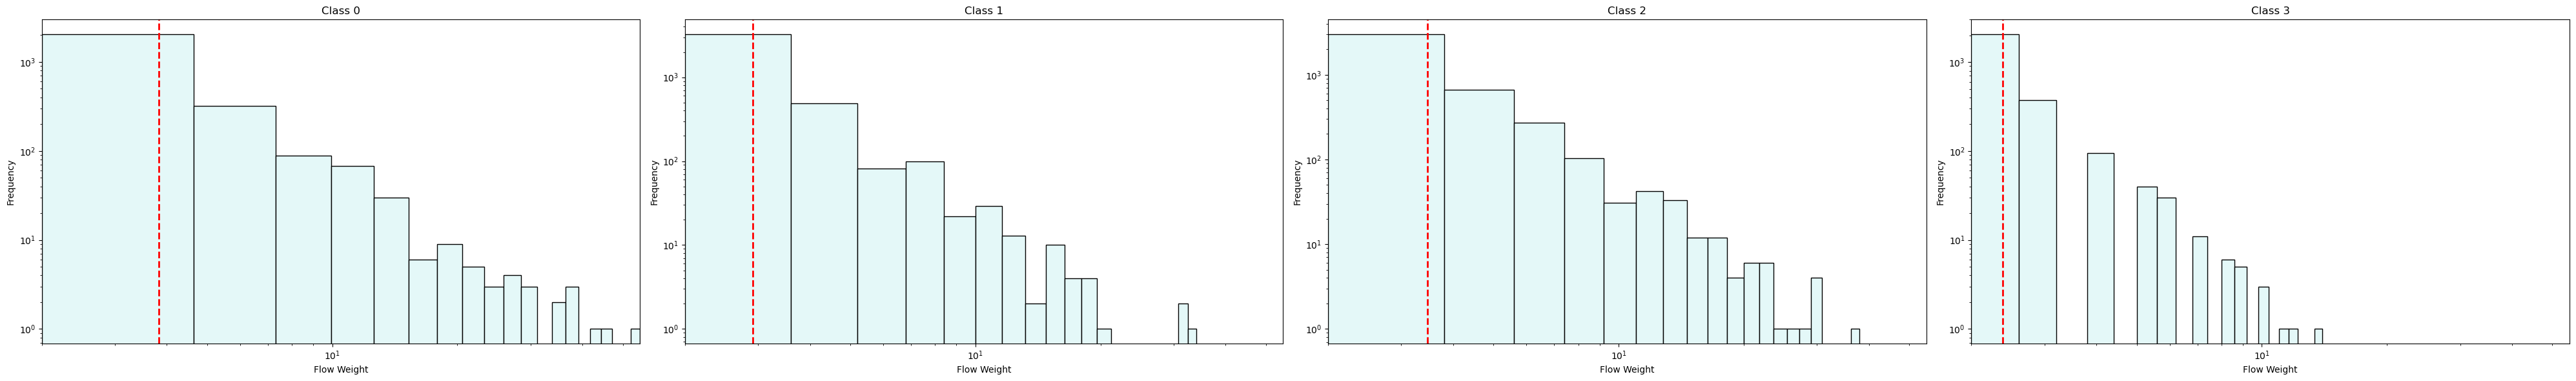

In [59]:
def flow_dis_diff_class(data, class_tot_num):
    global_min = data['flow_w'].min()
    global_max = data['flow_w'].max()
    
    # Calculate subplot grid size
    cols = 4  # Number of columns in the grid
    if class_tot_num<cols:
        cols = class_tot_num
    rows = -(-class_tot_num // cols)  # Ceiling division
    figsize = (10 * cols, 6 * rows)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
#     fig, axes = plt.subplots(-(-class_tot_num//3), 3, figsize=(15, 10))  # Adjust the grid to 3x4 to fit 11 subplots
    axes = axes.flatten()  # Flatten the axes for easy indexing

    # Loop through each class and plot the distribution in a separate subplot
    for class_num in range(class_tot_num):
        # Extract flow weights for the current class
        flow_w_one_class = data[data['class'] == class_num].flow_w.values
        mean_value = np.mean(flow_w_one_class)

        # Plot the distribution (using a histogram here, but you could use boxplot if preferred)
        axes[class_num].hist(flow_w_one_class, bins=20, color='#e4f8f8', edgecolor='black')
        axes[class_num].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
#         axes[class_num].axvline(x=10, color='r', linewidth=3) 
        # Set title and labels for each subplot
        axes[class_num].set_xscale('log')
        axes[class_num].set_yscale('log')
        axes[class_num].set_title(f'Class {class_num}')
        axes[class_num].set_xlabel('Flow Weight')
        axes[class_num].set_ylabel('Frequency')
        axes[class_num].set_xlim(global_min, global_max)

    # Hide any extra subplot (in case of fewer than 12)
    for i in range(11, len(axes)):
        axes[i].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

flow_dis_diff_class(evo_class_edge_xy, selected_class_num)

# 5. Performance on bidirectional flow (Table 3)

In [75]:
def reverse_flow(data):
    
    data = data.copy()
    merged = data.merge(data, left_on=['o_cbg', 'd_cbg'], right_on=['d_cbg', 'o_cbg'], suffixes=('_forward', '_reverse'))

    # Keep only rows where the origin and destination are not the same
    reverse_flows = merged[merged['o_cbg_forward'] != merged['d_cbg_forward']]
    reverse_flows['diff'] = reverse_flows['flow_w_forward']-reverse_flows['flow_w_reverse']
    reverse_flows['abs_diff'] = abs(reverse_flows['flow_w_forward']-reverse_flows['flow_w_reverse'])
    return reverse_flows

reverse_DSEN_evo = reverse_flow(DSEN_evo)
reverse_DSEN_evo = reverse_DSEN_evo[['o_cbg_forward', 'd_cbg_forward', 'Predict_flow_forward','flow_w_forward','Predict_flow_reverse', 'flow_w_reverse', 'diff', 'abs_diff']]
reverse_DSEN_evo.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w','Predict_flow_reverse', 'flow_w_reverse', 'diff', 'abs_diff']

reverse_DPG_test = reverse_flow(DPG_test)
reverse_DPG_test = reverse_DPG_test[['o_cbg_forward', 'd_cbg_forward', 'Predict_flow_forward','flow_w_forward','Predict_flow_reverse', 'flow_w_reverse', 'diff', 'abs_diff']]
reverse_DPG_test.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w','Predict_flow_reverse', 'flow_w_reverse', 'diff', 'abs_diff']

reverse_DG_test = reverse_flow(DG_test)
reverse_DG_test = reverse_DG_test[['o_cbg_forward', 'd_cbg_forward', 'Predict_flow_forward','flow_w_forward','Predict_flow_reverse', 'flow_w_reverse', 'diff', 'abs_diff']]
reverse_DG_test.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w','Predict_flow_reverse', 'flow_w_reverse', 'diff', 'abs_diff']

reverse_SIGCN = reverse_flow(SIGCN_df)
reverse_SIGCN = reverse_SIGCN[['o_cbg_forward', 'd_cbg_forward', 'Predict_flow_forward','flow_w_forward','Predict_flow_reverse', 'flow_w_reverse', 'diff', 'abs_diff']]
reverse_SIGCN.columns = ['o_cbg', 'd_cbg', 'Predict_flow', 'flow_w','Predict_flow_reverse', 'flow_w_reverse', 'diff', 'abs_diff']

reverse_reg_results_testset = reverse_flow(reg_results_testset)
reverse_reg_results_testset = reverse_reg_results_testset[['o_cbg_forward', 'd_cbg_forward', 'flow_w_forward', 'start_lat_forward',
       'start_lon_forward', 'end_lat_forward', 'end_lon_forward', 'y_pred_before_forward', 'y_pred_change_rate_forward',
       'y_pred_during_xmas_forward','y_pred_before_reverse', 'y_pred_change_rate_reverse',
       'y_pred_during_xmas_reverse', 'diff',
       'abs_diff']]
reverse_reg_results_testset.columns = ['o_cbg', 'd_cbg', 'flow_w', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'y_pred_before_forward', 'y_pred_change_rate_forward',
       'y_pred_during_xmas_forward','y_pred_before_reverse', 'y_pred_change_rate_reverse',
       'y_pred_during_xmas_reverse', 'diff',
       'abs_diff']

## Performance: bidirectional flow

In [92]:
model_list = [
    ("GM $P_{t_1}$",       reverse_reg_results_testset, "y_pred_before_forward"),
    ("GM $P_{t_2}$",  reverse_reg_results_testset, "y_pred_during_xmas_forward"),
    ("DGM",               reverse_DG_test,     "Predict_flow"),
    ("PGM-OLS",  reverse_reg_results_testset, "y_pred_change_rate_forward"),
    ("PGM-MLP",              reverse_DPG_test,    "Predict_flow"),
    ("SI-GCN",            reverse_SIGCN,       "Predict_flow"),
    ("DSEN",             reverse_DSEN_evo,    "Predict_flow")
]

results = []
for model_name, df_data, pred_col in model_list:
    cpc, rmse, corr, mape = eva_matrix(df_data, pred_col)
    results.append([model_name, cpc, rmse, corr, mape])

# Create a DataFrame with the desired columns
results_df = pd.DataFrame(results, columns=["Model", "CPC", "RMSE", "Corr", "MAPE"])

# Print or display the DataFrame
for col in ["CPC", "RMSE", "Corr", "MAPE"]:
    results_df[col] = results_df[col].apply(truncate4)
results_df

,Model,CPC,RMSE,Corr,MAPE
0,GM $P_{t_1}$,0.7308,4.3617,0.3964,38.8435
1,GM $P_{t_2}$,0.7289,4.3932,0.3665,39.9759
2,DGM,0.3568,19.9397,0.5359,485.7339
3,PGM-OLS,0.7326,4.3460,0.4114,38.8152
4,PGM-MLP,0.7927,3.2877,0.7264,36.2267
5,SI-GCN,0.7194,4.5977,0.1534,47.1538
6,DSEN,0.8165,2.6982,0.8246,35.2524


## Performance: single-directional flow

In [91]:
def exclude_reverse_flows(complete_set, reverse_set):
    # Convert reverse flows into a set of tuples for fast lookup
    reverse_pairs = set(zip(reverse_set['o_cbg'], reverse_set['d_cbg']))
    
    # Filter out rows in the complete set that are in the reverse pairs
    filtered_set = complete_set[
        ~complete_set.apply(lambda row: (row['o_cbg'], row['d_cbg']) in reverse_pairs, axis=1)
    ]
    
    return filtered_set

model_list = [
    ("GM $P_{t_1}$",       exclude_reverse_flows(reg_results_testset, reverse_reg_results_testset), "y_pred_before"),
    ("GM $P_{t_2}$",  exclude_reverse_flows(reg_results_testset, reverse_reg_results_testset), "y_pred_during_xmas"),
    ("DGM",               exclude_reverse_flows(DG_test, reverse_DG_test),     "Predict_flow"),
    ("PGM-OLS",  exclude_reverse_flows(reg_results_testset, reverse_reg_results_testset), "y_pred_change_rate"),
    ("PGM-MLP",              exclude_reverse_flows(DPG_test, reverse_DPG_test),    "Predict_flow"),
    ("SI-GCN",            exclude_reverse_flows(SIGCN_df, reverse_SIGCN),       "Predict_flow"),
    ("DSEN",             exclude_reverse_flows(DSEN_evo, reverse_DSEN_evo),    "Predict_flow")
]

results = []
for model_name, df_data, pred_col in model_list:
    cpc, rmse, corr, mape = eva_matrix(df_data, pred_col)
    results.append([model_name, cpc, rmse, corr, mape])

# Create a DataFrame with the desired columns
results_df = pd.DataFrame(results, columns=["Model", "CPC", "RMSE", "Corr", "MAPE"])

# Print or display the DataFrame
format_dict = {
    "CPC": "{:.4f}",
    "RMSE": "{:.4f}",
    "Corr": "{:.4f}",
    "MAPE": "{:.4f}"
}
results_df.style.format(format_dict)

,Model,CPC,RMSE,Corr,MAPE
0,GM $P_{t_1}$,0.8111,2.5084,0.4487,30.1835
1,GM $P_{t_2}$,0.8130,2.4925,0.4706,30.0186
2,DGM,0.3126,16.5231,0.5233,519.2261
3,PGM-OLS,0.8134,2.4876,0.4686,29.9082
4,PGM-MLP,0.8410,2.0151,0.6833,26.1879
5,SI-GCN,0.8211,2.1524,0.6146,31.0632
6,DSEN,0.8554,1.6816,0.7976,25.3413


# 6. Performance with different sampling ratio (Figure 6)

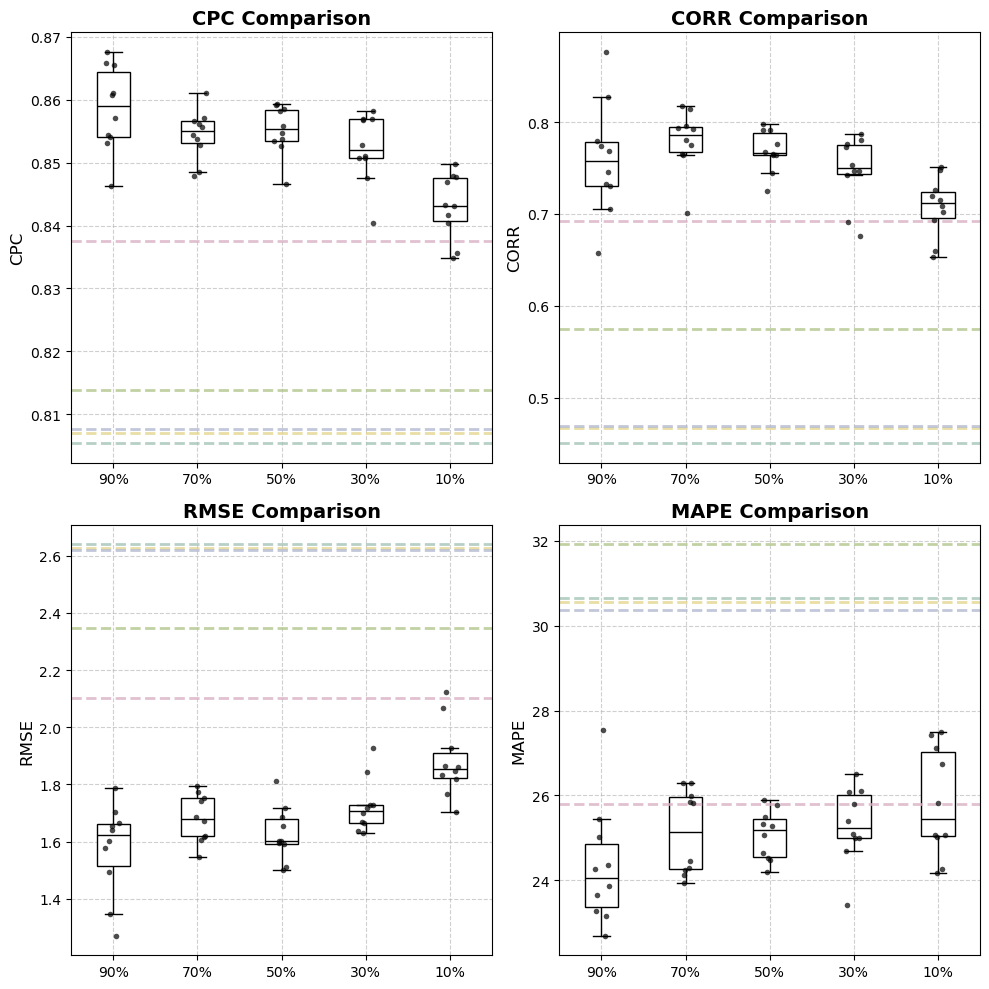

In [61]:
def diff_sample_ratio_eva(df_list, infer_flow_name = 'generated_flow', real_flow_name = 'Actual_flow'):
    
    index_df_ls = []
    for df_from_one in df_list:
        cpc_ls = []
        corr_ls = []
        rmse_ls = []
        mape_ls = []
        for df in df_from_one:
            real_flow = df[real_flow_name].values
            inferred_flow = df[infer_flow_name].values

            cpc = common_part_of_commuters(real_flow,inferred_flow)
            corr,_ = pearsonr(inferred_flow, real_flow)
            rmse = np.sqrt(np.mean((inferred_flow - real_flow) ** 2))
            mape = np.mean(np.abs((real_flow - inferred_flow) / real_flow)) * 100

            cpc_ls.append(cpc)
            corr_ls.append(corr)
            rmse_ls.append(rmse)
            mape_ls.append(mape)
        index_df = pd.DataFrame.from_dict({'cpc':cpc_ls, 'corr':corr_ls, 'rmse': rmse_ls, 'mape':mape_ls})
        index_df_ls.append(index_df)
    
    return index_df_ls

with open("DSEN_results/diff_sample_ratio.pkl", "rb") as f:
    diff_sample_ratio = pickle.load(f)
data = diff_sample_ratio_eva([diff_sample_ratio['sample_10'],
                     diff_sample_ratio['sample_30'],
                     diff_sample_ratio['sample_50'],
                     diff_sample_ratio['sample_70'], 
                     diff_sample_ratio['sample_90']])

dfs_by_column = {}

for col in ['cpc', 'corr', 'rmse', 'mape']:
    col_data = [df[col].reset_index(drop=True) for df in data]
    combined_df = pd.concat(col_data, axis=1)

    combined_df.columns = [f"{col}_{i}" for i in range(len(data))]

    dfs_by_column[col] = combined_df

# Baseline performance metrics
baseline_metrics = {
    'CPC': {
       'GM P_{t_1}': 0.8054,
       'GM P_{t_2}': 0.8071,
       'PGM': 0.8077,
       'PGM-MLP': 0.8375,
       'SIGCN': 0.8138,
    },
    'RMSE': {
       'GM P_{t_1}': 2.6392,
       'GM P_{t_2}': 2.6277,
       'PGM': 2.6191,
       'PGM-MLP': 2.1018,
       'SIGCN': 2.3464,
    },
    'CORR': {
       'GM P_{t_1}': 0.4503,
       'GM P_{t_2}': 0.4666,
       'PGM': 0.4688,
       'PGM-MLP': 0.6918,
       'SIGCN': 0.5747,
    },
    'MAPE': {
       'GM P_{t_1}': 30.6414,
       'GM P_{t_2}': 30.5452,
       'PGM': 30.3792,
       'PGM-MLP': 25.8042,
       'SIGCN': 31.9141,
    }
}

baseline_colors = {
    'GM P_{t_1}': '#A5C4B6',  
    'GM P_{t_2}': '#E4D68F',  
    'PGM': '#B3B9D1',         
    'PGM-MLP': '#DAB1C5',     
    'SIGCN': '#B2C68D',       
}

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# Loop through each metric
for i, (metric_key, df) in enumerate(dfs_by_column.items()):
    ax = axes[i]
    metric_upper = metric_key.upper()  # Ensure key is uppercase
    
    # Plot the boxplot (no color fill, only black outlines)
    sns.boxplot(data=df, ax=ax, color="white", width=0.4, boxprops=dict(edgecolor="black"),
                whiskerprops=dict(color="black"), capprops=dict(color="black"),
                medianprops=dict(color="black"), flierprops=dict(markeredgecolor="black"), showfliers=False)
    
    # Overlay the stripplot for individual data points
    sns.stripplot(data=df, ax=ax, color='black', size=4, jitter=True, alpha=0.7)
    
    # Collect all y-values to adjust y-axis limits
    data_values = np.concatenate([df[col].dropna().values for col in df.columns])
    
    # If baseline metrics exist for this metric, add horizontal lines with new colors
    if metric_upper in baseline_metrics:
        for model, value in baseline_metrics[metric_upper].items():
            ax.axhline(y=value, color=baseline_colors.get(model, 'gray'),
                       linestyle='--', linewidth=2, alpha=0.8)
        
        # Expand y-axis to ensure all baseline values are visible
        combined_y = np.append(data_values, list(baseline_metrics[metric_upper].values()))
        ax.set_ylim(np.min(combined_y) - 0.05 * np.ptp(combined_y),
                    np.max(combined_y) + 0.05 * np.ptp(combined_y))
    
    # Set title and labels
    ax.set_title(f'{metric_upper} Comparison', fontsize=14, weight='bold')
    ax.set_ylabel(metric_upper, fontsize=12)
    
    # Reverse x-tick labels and order
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(['10%', '30%', '50%', '70%', '90%'])  
    
    # Invert the x-axis so 90% is on the left
    ax.invert_xaxis()
    
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### Additional Note

All the flow map visualizations presented in our work are derived from the results shown here and were implemented using ArcGIS Pro.
